# This file will be where all of our content resides at the end of the project. A Deliverables are below, other visualizations can be found in the Population_Map_and_Visualizations and Additional_Visualization files for now.

In [14]:
%pip install wbdata
%pip install pandas
%pip install iso3166
%pip install cufflinks
%pip install eep153_tools
%pip install plotly
%pip install kagglehub
%pip install os

import wbdata
import pandas as pd
import geopandas as gpd
import math
import iso3166
import plotly.offline as py
from scipy.optimize import newton
import plotly.graph_objs as go
import numpy as np
import cufflinks as cf
from matplotlib import animation as ani
import matplotlib.pyplot as plt
import kagglehub
import os
cf.go_offline()

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os
Note: you may need to restart the kernel to use updated packages.


## [A] Population Statistics

Below is a population function that when input with parameters year, sex, age_range, and place, returns the total population given the constraints (eg. population(2000, 'male', (20, 60), 'brazil')). 

In [12]:
def population(year, sex, age_range, place):
    def age_helper(age_range):
        lower, upper = age_range
        start = (lower // 5) * 5
        age_ranges = []
        for age in range(start, upper + 1, 5):
            if age >= 80:
                age_ranges.append("80UP")
                break
            next_age = age + 4
            if next_age >= 80:
                age_ranges.append("80UP")
                break
            age_ranges.append(f"{age:02d}{next_age:02d}")
        return age_ranges

    # Generate the age ranges
    age_ranges = age_helper(age_range)


    if place.lower() == "world":
        name_alpha3 = "WLD"
        name_actual = "World"
        name_name = 'World'
    else:
        name_name = iso3166.countries.get(place).name
        name_alpha2 = iso3166.countries.get(place).alpha2
        name_alpha3 = iso3166.countries.get(place).alpha3
        name_numeric = iso3166.countries.get(place).numeric
        name_actual = iso3166.countries.get(place).apolitical_name

    # Construct the indicator codes
    indicator = 'SP.POP.'
    sex_indicators = []
    for age in age_ranges:
        if sex.lower() == 'male':
            sex_indicators.append(f"{indicator}{age}.MA")
        elif sex.lower() == 'female':
            sex_indicators.append(f"{indicator}{age}.FE")
        elif sex.lower() == 'both':
            sex_indicators.append(f"{indicator}{age}.MA")
            sex_indicators.append(f"{indicator}{age}.FE")
        else:
            print('Please choose Male, Female, or Both')
            return


    # Prepare the indicators for wbdata
    pop_indicators = {ind: "Population" for ind in sex_indicators}
    total = 0
    for i in pop_indicators:
        hold = {i:"Population"}
        retrieve_year = wbdata.get_dataframe(hold, country=name_alpha3, date=(str(year), str(year)), parse_dates=True)
        retrieve_year = retrieve_year.reset_index()
       # print(retrieve_year)
        total += retrieve_year['Population'].iloc[0].item() 
    #return retrieve_year['Population'].iloc[0].item() #problem here is we need to sum up all of the populations

    print("In the year {}, there are {} {}s aged {} to {} living in {}.".format(year, total, sex, age_range[0], age_range[1], name_name))
    return total

## [A] Unit Tests

Below are Unit tests made to test population function. The tests are made up of a series of basic inputs, as well as many to test edge cases.

In [12]:
# Test 1: Standard input - Brazil, male, ages 20-60 in 2000
assert population(2000, 'male', (20, 60), 'brazil') == 47111262.0

# Test 2: Ecuador, female population, ages 0-4 in 2010
assert population(2010, 'female', (0, 4), 'ecuador') == 784333.0

# Test 3: Colombia, unspecified sex, ages 80+ in 1995
assert population(1995, 'both', (80, 100), 'colombia') == 252931.0

# Test 4: Venezuela, male population, single age group (25-29) in 2020
assert population(2020, 'male', (25, 29), 'VEN') == 972737.0

# Test 5: World population, female, ages 10-14 in 2015
assert population(2015, 'female', (10, 14), 'world') == 303263011.0  # Placeholder value for global data

# Test 6: Edge case - Minimum age range (0-0), unspecified sex, Ecuador, 2005
assert population(2005, 'unspecified', (0, 4), 'ecuador') == print('Please choose Male, Female, or Both')

# Test 7: Edge case - Maximum age range (0-100), male, Colombia, 1990
assert population(1990, 'male', (0, 100), 'colombia') == 16197631.0 

# Test 8: Invalid sex input ("other"), Venezuela, ages 20-24 in 2010
assert population(2010, 'other', (20, 24), 'Venezuela, Bolivarian Republic of') == print('Please choose Male, Female, or Both')

# Test 9: Case insensitivity - BRAZIL (uppercase), FeMale (mixed case), ages 30-34 in 2015
assert population(2015, 'FeMale', (30, 34), 'BRAZIL') == 8612358.0  # Placeholder value

# Test 10: Single country code input - using ISO code for Colombia ('COL'), male, ages 15-19 in 2000
assert population(2000, 'male', (15, 19), 'COL') == 1966993.0

In the year 2000, there are 47111262.0 males aged 20 to 60 living in Brazil.
In the year 2010, there are 784333.0 females aged 0 to 4 living in Ecuador.
In the year 1995, there are 252931.0 boths aged 80 to 100 living in Colombia.
In the year 2020, there are 972737.0 males aged 25 to 29 living in Venezuela, Bolivarian Republic of.
In the year 2015, there are 303263011.0 females aged 10 to 14 living in World.
Please choose Male, Female, or Both
Please choose Male, Female, or Both
In the year 1990, there are 16197631.0 males aged 0 to 100 living in Colombia.
Please choose Male, Female, or Both
Please choose Male, Female, or Both
In the year 2015, there are 8612358.0 FeMales aged 30 to 34 living in Brazil.
In the year 2000, there are 1966993.0 males aged 15 to 19 living in Colombia.


## [A] Population Dataframe

Below is a function that will return a dataframe containint the male, female, or all populations given a specific country and year.

In [7]:
def pop_df(year, sex, country):
    def age_helper(age_range):
        lower, upper = age_range
        start = (lower // 5) * 5
        age_ranges = []
        for age in range(start, upper + 1, 5):
            if age >= 80:
                age_ranges.append("80UP")
                break
            next_age = age + 4
            if next_age >= 80:
                age_ranges.append("80UP")
                break
            age_ranges.append(f"{age:02d}{next_age:02d}")
        return age_ranges

    # Generate the age ranges
    age_ranges = age_helper((0,81))


    if country.lower() == "world":
        name_alpha3 = "WLD"
        name_actual = "World"
    else:
        name_alpha3 = iso3166.countries.get(country).alpha3
        name_actual = iso3166.countries.get(country).apolitical_name

    # Construct the indicator codes
    indicator = 'SP.POP.'
    male_indicators = []
    female_indicators = []
    for age in age_ranges:
        if sex.lower() == 'male':
            male_indicators.append(f"{indicator}{age}.MA")
        elif sex.lower() == 'female':
            female_indicators.append(f"{indicator}{age}.FE")
        else:
            male_indicators.append(f"{indicator}{age}.MA")
            female_indicators.append(f"{indicator}{age}.FE")
 
   #Preparing the initial data frame whether or not its one or both sexes
    if male_indicators:
        hold = {male_indicators[0]:"Male"}
        retrieve_year = wbdata.get_dataframe(hold, country=name_alpha3, date=(str(year), str(year)), parse_dates=True)
        final = retrieve_year.reset_index()
        final['Country'] = name_actual
        male_indicators = male_indicators[1:]
        female=pd.DataFrame()
        
    else:
        hold = {female_indicators[0]:"Female"}
        retrieve_year = wbdata.get_dataframe(hold, country=name_alpha3, date=(str(year), str(year)), parse_dates=True)
        female = retrieve_year.reset_index()
        female['Country'] = name_actual
        female_indicators = female_indicators[1:]


    #Concatenating all of the data frames of populations and assigning labels
        
    for i in male_indicators:
        hold = {i:"Male"}
        retrieve_year = wbdata.get_dataframe(hold, country=name_alpha3, date=(str(year), str(year)), parse_dates=True)
        retrieve_year = retrieve_year.reset_index()
        retrieve_year['Country'] = name_actual
        final = pd.concat([final, retrieve_year], axis=0)

    if male_indicators:
        final['Ages'] = ["0-4","5-9","10-14","15-19","20-24","25-29","30-34","35-39","40-44","45-49","50-54","55-59","60-64","65-69","70-74","75-79","80+"]

    for i in female_indicators:
        hold = {i:"Female"}
        retrieve_year = wbdata.get_dataframe(hold, country=name_alpha3, date=(str(year), str(year)), parse_dates=True)
        retrieve_year = retrieve_year.reset_index()
        retrieve_year['Country'] = name_actual
        female = pd.concat([female, retrieve_year], axis=0)

    if female_indicators:
        female['Ages'] = ["0-4","5-9","10-14","15-19","20-24","25-29","30-34","35-39","40-44","45-49","50-54","55-59","60-64","65-69","70-74","75-79","80+"]
        if male_indicators:
            final = final.merge(female, on=["Ages","date","Country"])
        else:
            final = female

    
    return final


result = pop_df(1990, 'both', 'brazil')
result

,date,Male,Country,Ages,Female
0,1990-01-01,9151216.0,Brazil,0-4,8854763.0
1,1990-01-01,9196771.0,Brazil,5-9,8954043.0
2,1990-01-01,8466552.0,Brazil,10-14,8308372.0
3,1990-01-01,7560006.0,Brazil,15-19,7459561.0
4,1990-01-01,6937745.0,Brazil,20-24,6889244.0
5,1990-01-01,6573141.0,Brazil,25-29,6565302.0
6,1990-01-01,5733650.0,Brazil,30-34,5755618.0
7,1990-01-01,4783833.0,Brazil,35-39,4835453.0
8,1990-01-01,3800667.0,Brazil,40-44,3848138.0
9,1990-01-01,3089321.0,Brazil,45-49,3037437.0


## [C] Visualization Tools

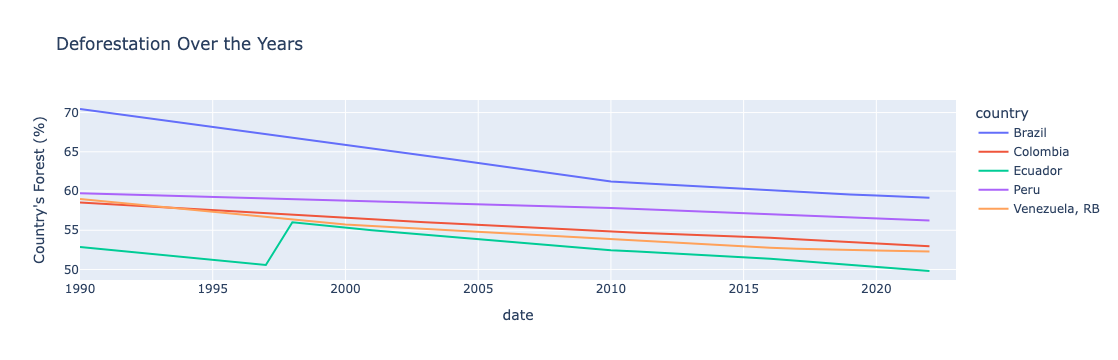

country,Brazil,Colombia,Ecuador,Peru,"Venezuela, RB"
date,,,,,
1990-01-01,70.458021,58.547219,52.854392,59.725422,58.983051
1991-01-01,70.005654,58.346891,52.528677,59.635523,58.657106
1992-01-01,69.553288,58.146563,52.202962,59.545623,58.331160
1993-01-01,69.100922,57.946235,51.877247,59.455724,58.005215
1994-01-01,68.648556,57.745907,51.551532,59.365825,57.679270


In [9]:
vars = {"AG.LND.FRST.ZS":"Deforestation"}

use=["BRA","ECU","VEN","COL","PER"]

deforestation = wbdata.get_dataframe(vars,country=use,parse_dates=True).squeeze().unstack('country')

deforestation = deforestation.loc["1990":]

plot = deforestation.plot(title="Deforestation Over the Years", labels={"index": "Year", "value": "Country's Forest (%)"})
plot.show()
deforestation.head()

## [C] Population Map

## [C] Agriculture Supply